In [1]:
%matplotlib inline
from parcels import FieldSet, ParticleSet, Variable, JITParticle, AdvectionRK4, AdvectionEE, plotTrajectoriesFile
import numpy as np
import math
import cftime
import datetime 
from operator import attrgetter

import netCDF4 as nc
import xarray as xr
import pandas as pd

from cartopy import crs
import cartopy

### Load data from netCDF files

In [2]:
ds = xr.open_mfdataset('../data/ncom_socal/socal_2017-01-0[0-9].nc')

In [3]:
uv = ds[['water_u', 'water_v']]
uv = uv.isel(depth=0)
uv

<xarray.Dataset>
Dimensions:  (lat: 454, lon: 424, time: 64)
Coordinates:
  * lon      (lon) float64 235.0 235.0 235.1 235.1 ... 249.0 249.0 249.1 249.1
  * lat      (lat) float64 25.0 25.03 25.07 25.1 25.13 ... 40.0 40.03 40.07 40.1
  * time     (time) datetime64[ns] 2017-01-01 ... 2017-01-09T21:00:00
    depth    float64 0.0
Data variables:
    water_u  (time, lat, lon) float32 dask.array<shape=(64, 454, 424), chunksize=(8, 454, 424)>
    water_v  (time, lat, lon) float32 dask.array<shape=(64, 454, 424), chunksize=(8, 454, 424)>
Attributes:
    title:                     NCOM Southern CA Regional Forecast (3km)
    summary:                   The Regional NCOM models have a resolution of ...
    keywords:                  OCEANS; OCEAN CIRCULATION; OCEAN CURRENTS, OCE...
    keywords_vocabulary:       Olsen, L.M., G. Major, K. Shein, J. Scialdone,...
    standard_name_vocabulary:  CF Standard Names Vocabulary V27
    creator_url:               http://www7320.nrlssc.navy.mil/global_nco

### Setup Input U/V Data

In [4]:
variables = {
    'U': 'water_u',
    'V': 'water_v'
}

dimensions = {
    'lat': 'lat',
    'lon': 'lon',
    'time': 'time'
}

In [5]:
xr_fieldset = FieldSet.from_xarray_dataset(
    uv,
    variables,
    dimensions,
    allow_time_extrapolation=True
)

In [6]:
xr_pset = ParticleSet.from_line(
    fieldset=xr_fieldset,
    pclass=JITParticle,
    size=100,
    start=(236, 28.8),
    finish=(245, 28.8)
)

INFO: Compiled JITParticleAdvectionRK4 ==> /tmp/parcels-1000/a724bc4b90f9132791ab9ade03e4ffb5.so
100% (518400.0 of 518400.0) |############| Elapsed Time: 0:00:33 Time:  0:00:33


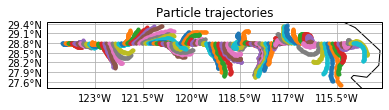

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [7]:
runlength = datetime.timedelta(days=6)
timestep = datetime.timedelta(minutes=5)
output_file = '../data/particle_runs/NCOM_Particles_from_line.nc'
output = xr_pset.ParticleFile(name=output_file, outputdt=datetime.timedelta(hours=3))

xr_pset.execute(
    AdvectionRK4,
    runtime=runlength,
    dt=timestep,
    output_file=output
)
plotTrajectoriesFile(output_file)

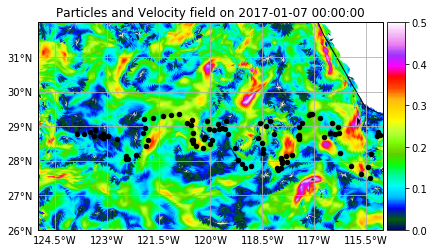

In [8]:
xr_pset.show(field='vector',
             vmax=0.5,
             domain=[32, 26, 245, 235],
             projection=cartopy.crs.PlateCarree(),
             land=True,
            )

### Plotting example

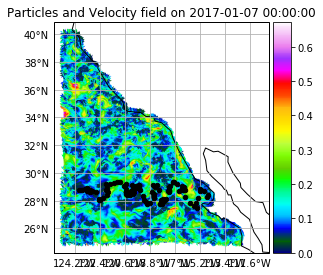

In [9]:
xr_pset.show(field='vector', projection=crs.PlateCarree())

### Run from release config file

In [10]:
def read_particle_csv(filename):
    """Given filename return dataframe of particles to release"""
    df = pd.read_csv(filename,
                       header=None, 
                       names=['time', 'lat', 'lon', 'nparticles'],
                       parse_dates=[0],
                       infer_datetime_format=True)
    display(df)
    # alter dataframe to account for nparticles
    expanded_rows = []
    for ix, row in df.iterrows():
        expanded_rows.append(pd.concat([row]*row.nparticles, ignore_index=True, axis=1).T)
    new_df = pd.concat(expanded_rows, axis=0).reset_index()
    new_df = new_df.drop(columns=['index', 'nparticles'])
    
    return new_df

In [11]:
df = read_particle_csv('../data/particle_sample.csv')

,time,lat,lon,nparticles
0,2017-01-01 00:00:00,26.0,236.0,2
1,2017-01-01 12:00:00,26.5,236.5,4
2,2017-01-02 00:00:00,27.0,237.0,8
3,2017-01-02 12:00:00,27.5,237.5,16
4,2017-01-03 00:00:00,28.0,238.0,32
5,2017-01-03 12:00:00,28.5,238.5,64


In [12]:
particle_times = cftime.date2num(
    pd.DatetimeIndex(df.time).to_pydatetime(),
    units='hours since 1970-01-01 00:00:00'
)

csv_pset = ParticleSet.from_list(
    fieldset=xr_fieldset,
    pclass=JITParticle,
    lon=df.lon,
    lat=df.lat,
    time=particle_times
)

INFO: Compiled JITParticleAdvectionRK4 ==> /tmp/parcels-1000/910c6e9f9a18c0b006a1229543d2b020.so
100% (518400.0 of 518400.0) |############| Elapsed Time: 0:00:20 Time:  0:00:20
/opt/conda/lib/python3.6/site-packages/xarray/coding/times.py:92: RuntimeWarning: invalid value encountered in greater
  only_use_cftime_datetimes=True))


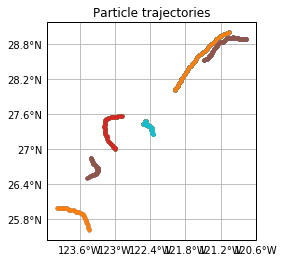

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [13]:
runlength = datetime.timedelta(days=6)
timestep = datetime.timedelta(minutes=5)
output_file = '../data/particle_runs/NCOM_Particles_from_config.nc'
output = csv_pset.ParticleFile(name=output_file, outputdt=datetime.timedelta(hours=3))

csv_pset.execute(
    AdvectionRK4,
    runtime=runlength,
    dt=timestep,
    output_file=output
)
plotTrajectoriesFile(output_file)

In [14]:
plotTrajectoriesFile(output_file, mode='movie2d_notebook')